In [ ]:
#installing yfinance in order to access stock market data
!pip install yfinance -U

In [ ]:
import yfinance as yf
from datetime import datetime
import json
import requests
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import seaborn as sns
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#laying the groundwork for downloading data faster
yf.pdr_override()

In [ ]:
#importing the datetime model in order to track the market
now=datetime.now()

In [ ]:
#checking Apple's stock from 1-1-2017 five years onward
fin=yf.download('AAPL',datetime(2017,1,1),datetime(2022,1,1))
fin

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059307,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029024,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166475,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469334,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720940,134247600
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.527771,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.498154,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.587265,62348900


In [ ]:
fin['Average']=(fin['High']+fin['Low'])/2

In [ ]:
fin

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059307,115127600,28.886250
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029024,84472400,29.032500
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166475,88774400,29.083750
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469334,127007600,29.328751
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720940,134247600,29.671250
...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.527771,74919600,178.745003
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.498154,79144300,179.930000
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.587265,62348900,179.385002


In [ ]:
#reading the json file that contains the headlines
def read_json_file(file):
    with open(file, "r") as r:
        response=r.read()
        response=response.replace('\n', '')
        response=response.replace('}{', '},{')
        response="[" + response + "]"
        for i in range(len(response)):
          if i==48234498:
            list(response)[i]=""
        return json.loads(response)
f="/content/News_Category_Dataset_v3.json"
headlines=read_json_file(f)
headlines[:3]

[{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9',
  'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
  'category': 'U.S. NEWS',
  'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
  'authors': 'Carla K. Johnson, AP',
  'date': '2022-09-23'},
 {'link': 'https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe',
  'headline': 'American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video',
  'category': 'U.S. NEWS',
  'short_description': "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
  'authors': 'Mary Papenfuss',
  'date': '2022-09-23'},
 {'link': 'https

In [ ]:
headlines=pd.DataFrame(headlines, columns=['link','headline','category','short_description','authors','date'])

In [ ]:
headlines

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [ ]:
headlines=headlines[(pd.to_datetime(headlines["date"])>=datetime(2017,1,1))&(pd.to_datetime(headlines["date"])<=datetime(2022,1,1))]
headlines.head()

,link,headline,category,short_description,authors,date
1392,https://www.huffpost.com/entry/times-square-ba...,New York City Rings In 2022 With Times Square ...,U.S. NEWS,"The city’s incoming mayor, Eric Adams, took hi...","By BOBBY CAINA CALVAN, AP",2022-01-01
1393,https://www.huffpost.com/entry/alexandria-ocas...,Rep. Alexandria Ocasio-Cortez Rips 'Creepy Wei...,POLITICS,The congresswoman fired back at Republican Ste...,Mary Papenfuss,2022-01-01
1394,https://www.huffpost.com/entry/ap-eu-austria-o...,Austrian Holocaust Survivor 'Mrs. Gertrude' Di...,WORLD NEWS,Gertrude Pressburger became famous during Aust...,"Kirsten Grieshaber, AP",2022-01-01
1395,https://www.huffpost.com/entry/covid-rapid-tes...,Taking A COVID Rapid Test? You May Want To Swa...,WELLNESS,Swabbing both areas when using an at-home test...,Julia Ries,2022-01-01
1396,https://www.huffpost.com/entry/sandia-peak-tra...,21 People Rescued After Being Stuck Overnight ...,U.S. NEWS,The riders spent a harrowing New Year's Eve in...,Hilary Hanson,2022-01-01


In [ ]:
#finding all the different kinds of news categories, in order to decide which to focus on
headlines["category"].unique()

array(['U.S. NEWS', 'POLITICS', 'WORLD NEWS', 'WELLNESS', 'ENTERTAINMENT',
       'COMEDY', 'STYLE & BEAUTY', 'ENVIRONMENT', 'FOOD & DRINK',
       'HOME & LIVING', 'CRIME', 'BUSINESS', 'SCIENCE', 'SPORTS',
       'TRAVEL', 'PARENTING', 'WOMEN', 'WEIRD NEWS', 'BLACK VOICES',
       'MEDIA', 'TECH', 'MONEY', 'RELIGION', 'EDUCATION',
       'CULTURE & ARTS', 'QUEER VOICES', 'LATINO VOICES', 'IMPACT',
       'WEDDINGS', 'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE',
       'GREEN', 'TASTE', 'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS',
       'WORLDPOST', 'FIFTY', 'ARTS'], dtype=object)

US News, Tech, Science, Business, and Money all are related to the economy. Analyzing those categories for their sentiments could point us in the right direction as to the movements in the stock market.

In [ ]:
headlines=headlines[(headlines["category"]=="US NEWS")|(headlines["category"]=="TECH")|(headlines["category"]=="SCIENCE")|(headlines["category"]=="BUSINESS")|(headlines["category"]=="MONEY")]

In [ ]:
headlines

,link,headline,category,short_description,authors,date
1430,https://www.huffpost.com/entry/holiday-sales-r...,Holiday Sales Rise Despite Supply Issues And O...,BUSINESS,"After omicron hit, some consumers stayed home ...","Paul Wiseman and Anne D'Innocenzio, AP",2021-12-26
1455,https://www.huffpost.com/entry/stellars-sea-ea...,"Rare Sea Eagle, Native To Asia, Turns Up In Ma...",SCIENCE,A once-in-a-lifetime sighting has bird lovers ...,Chris D'Angelo,2021-12-21
1468,https://www.huffpost.com/entry/ransomware-atta...,Low-Profile Ransomware Attacks Continue As Hig...,BUSINESS,"Cyberattacks have interrupted schools, hospita...","Eric Tucker and Alan Suderman Washington, AP",2021-12-18
1573,https://www.huffpost.com/entry/nasa-spacewalk-...,"Space Junk Too Risky For Astronaut, Spacewalk ...",SCIENCE,It’s the first time a spacewalk has been cance...,"Marcia Dunn, AP",2021-11-30
1595,https://www.huffpost.com/entry/bc-us-black-fri...,Stores Kick Off Black Friday But Pandemic Woes...,BUSINESS,Retailers are expected to usher in the unoffic...,"ANNE D'INNOCENZIO, AP",2021-11-26
...,...,...,...,...,...,...
47065,https://www.huffingtonpost.com/entry/5-times-t...,5 Times to Pick Up the Telephone Instead,BUSINESS,,"Caroline Beaton, ContributorI cover the psycho...",2017-01-02
47071,https://www.huffingtonpost.com/entry/a-kink-in...,A Kink in the Works,BUSINESS,,"Martha Ringer, ContributorFormer banking execu...",2017-01-02
47111,https://www.huffingtonpost.com/entry/is-apple-...,Is Apple Near The End Of Their Run?,TECH,Is Apple near the end of their run? Apple has ...,"Dominique Clare, ContributorContent Director a...",2017-01-01
47124,https://www.huffingtonpost.com/entry/former-at...,Former Atheist Mark Zuckerberg Gets Religion,BUSINESS,"""I went through a period when I questioned thi...",Mary Papenfuss,2017-01-01


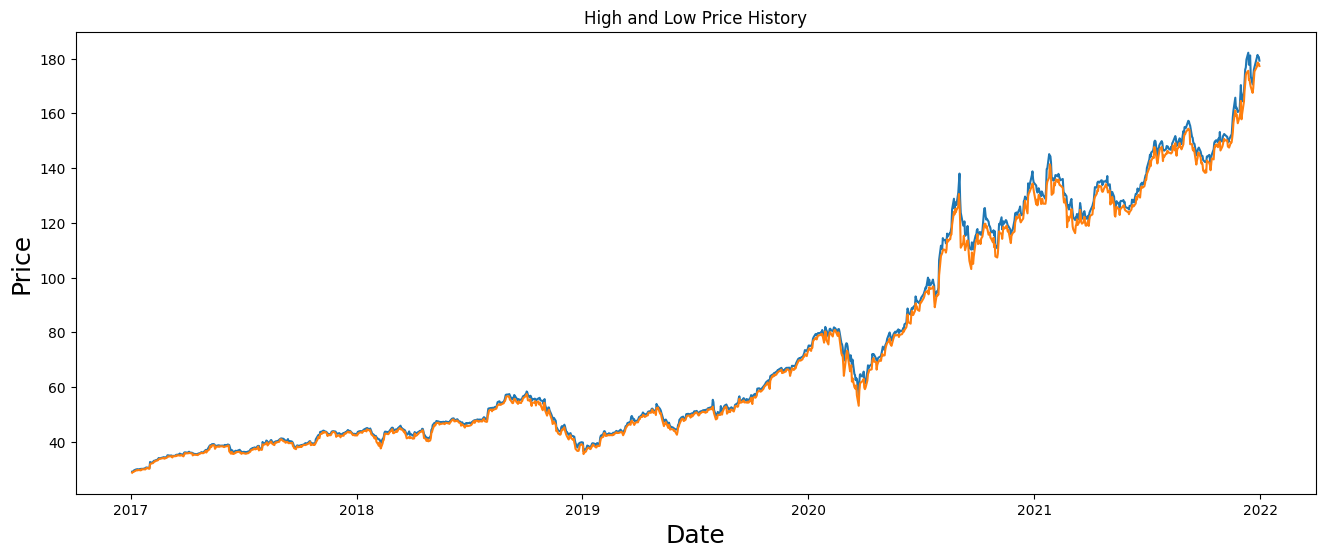

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.title('High and Low Price History')
plt.plot(fin['High'])
plt.plot(fin['Low'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(fin.loc[:,fin.columns!='Average'],fin['Average'],test_size=0.3)

In [ ]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(881, 6) (881,) (378, 6) (378,)


In [ ]:
x_train=np.array(x_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [ ]:
model=Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

881/881 [==============================] - 24s 14ms/step - loss: 983.1960


In [ ]:
y_pred=model.predict(x_test)
y_test=np.array(y_test)
rmse=np.sqrt(np.mean((y_pred-y_test) ** 2))
rmse

12/12 [==============================] - 1s 10ms/step


58.98738469613645

In [ ]:
model.evaluate(x_test, y_test, verbose = 0)

149.0916290283203

In [ ]:
model.metrics_names

['loss']

In [ ]:
sia = SentimentIntensityAnalyzer()
def is_positive(string):
  if sia.polarity_scores(string)['compound']>0:
    return("Positive")
  else:
    return("Negative")
#We will use the short descriptions to analyze our dataset, because headlines can be

In [ ]:
descriptions=headlines['short_description']
sentiment=[]
for desc in descriptions:
    sentiment.append(is_positive(desc))

In [ ]:
headlines['sentiment']=sentiment

In [ ]:
headlines

,link,headline,category,short_description,authors,date,sentiment
1430,https://www.huffpost.com/entry/holiday-sales-r...,Holiday Sales Rise Despite Supply Issues And O...,BUSINESS,"After omicron hit, some consumers stayed home ...","Paul Wiseman and Anne D'Innocenzio, AP",2021-12-26,Positive
1455,https://www.huffpost.com/entry/stellars-sea-ea...,"Rare Sea Eagle, Native To Asia, Turns Up In Ma...",SCIENCE,A once-in-a-lifetime sighting has bird lovers ...,Chris D'Angelo,2021-12-21,Positive
1468,https://www.huffpost.com/entry/ransomware-atta...,Low-Profile Ransomware Attacks Continue As Hig...,BUSINESS,"Cyberattacks have interrupted schools, hospita...","Eric Tucker and Alan Suderman Washington, AP",2021-12-18,Negative
1573,https://www.huffpost.com/entry/nasa-spacewalk-...,"Space Junk Too Risky For Astronaut, Spacewalk ...",SCIENCE,It’s the first time a spacewalk has been cance...,"Marcia Dunn, AP",2021-11-30,Negative
1595,https://www.huffpost.com/entry/bc-us-black-fri...,Stores Kick Off Black Friday But Pandemic Woes...,BUSINESS,Retailers are expected to usher in the unoffic...,"ANNE D'INNOCENZIO, AP",2021-11-26,Positive
...,...,...,...,...,...,...,...
47065,https://www.huffingtonpost.com/entry/5-times-t...,5 Times to Pick Up the Telephone Instead,BUSINESS,,"Caroline Beaton, ContributorI cover the psycho...",2017-01-02,Negative
47071,https://www.huffingtonpost.com/entry/a-kink-in...,A Kink in the Works,BUSINESS,,"Martha Ringer, ContributorFormer banking execu...",2017-01-02,Negative
47111,https://www.huffingtonpost.com/entry/is-apple-...,Is Apple Near The End Of Their Run?,TECH,Is Apple near the end of their run? Apple has ...,"Dominique Clare, ContributorContent Director a...",2017-01-01,Positive
47124,https://www.huffingtonpost.com/entry/former-at...,Former Atheist Mark Zuckerberg Gets Religion,BUSINESS,"""I went through a period when I questioned thi...",Mary Papenfuss,2017-01-01,Negative


In [ ]:
fin['Date']=fin.index.get_level_values(0)

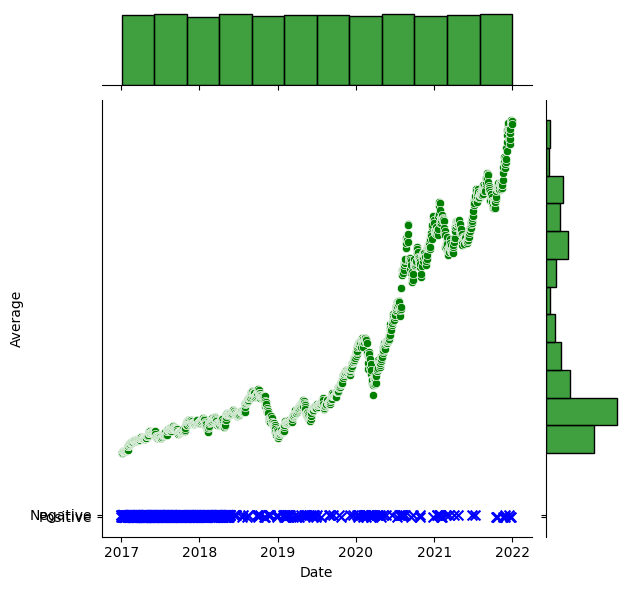

In [ ]:
graph = sns.jointplot(x=fin.Date, y=fin.Average, color='g')

graph.x = headlines.date
graph.y = headlines.sentiment
graph.plot_joint(plt.scatter, marker='x', c='b', s=50)

In [ ]:
#We can see from the joint plot that there is no real coorelation between the frequency of positive articles and the average of the stock. Perhaps we
#we should consider the percentage of positive articles instead?
a=0
b=1
year=2021
percentage=[]
for index,row in headlines.iterrows():
  row['date']=datetime.strptime(row['date'],'%Y-%m-%d')
  if row['date'].year!=year:
    b=1
    a=0
  else:
    b+=1
  if row['sentiment']=='Positive':
    a+=1
  percentage.append((a/b)*100)
  year=row['date'].year

In [ ]:
headlines['percentage']=percentage

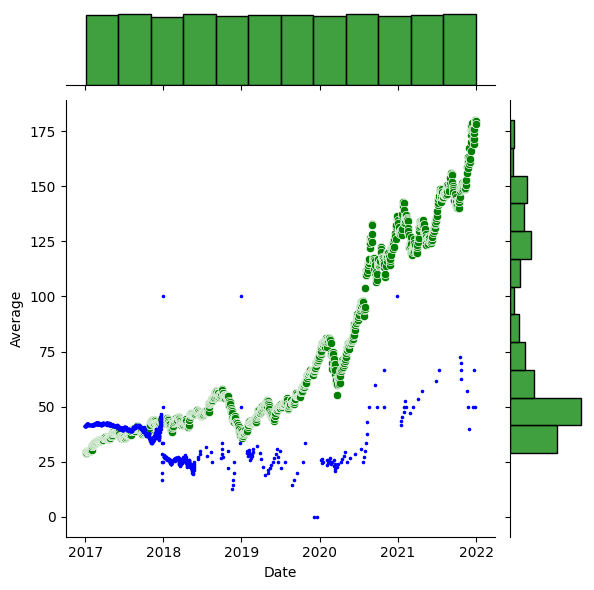

In [ ]:
graph2 = sns.jointplot(x=fin.Date, y=fin.Average, color='g')

graph2.x = headlines.date
graph2.y = headlines.percentage
graph2.plot_joint(plt.scatter, marker='.', c='b', s=10)

In [ ]:
#Here we can see that as the percentage of positive articles increases, the rate at which the stock grows increases too.

In [ ]:
fin.reset_index(drop = True, inplace = True)
headlines.reset_index(drop = True, inplace = True)
fin['Date']=pd.to_datetime(fin['Date'], utc=True)
headlines['date']=pd.to_datetime(headlines['date'], utc=True)
combo=pd.merge(headlines,fin, left_on = 'date', right_on = 'Date', how = 'inner')

In [ ]:
combo

,link,headline,category,short_description,authors,date,sentiment,percentage,Open,High,Low,Close,Adj Close,Volume,Average,Date
0,https://www.huffpost.com/entry/stellars-sea-ea...,"Rare Sea Eagle, Native To Asia, Turns Up In Ma...",SCIENCE,A once-in-a-lifetime sighting has bird lovers ...,Chris D'Angelo,2021-12-21 00:00:00+00:00,Positive,66.666667,171.559998,173.199997,169.119995,172.990005,171.261108,91185900,171.159996,2021-12-21 00:00:00+00:00
1,https://www.huffpost.com/entry/nasa-spacewalk-...,"Space Junk Too Risky For Astronaut, Spacewalk ...",SCIENCE,It’s the first time a spacewalk has been cance...,"Marcia Dunn, AP",2021-11-30 00:00:00+00:00,Negative,40.000000,159.990005,165.520004,159.919998,165.300003,163.647995,174048100,162.720001,2021-11-30 00:00:00+00:00
2,https://www.huffpost.com/entry/bc-us-black-fri...,Stores Kick Off Black Friday But Pandemic Woes...,BUSINESS,Retailers are expected to usher in the unoffic...,"ANNE D'INNOCENZIO, AP",2021-11-26 00:00:00+00:00,Positive,50.000000,159.570007,160.449997,156.360001,156.809998,155.242813,76959800,158.404999,2021-11-26 00:00:00+00:00
3,https://www.huffpost.com/entry/apple-self-repa...,"Under Pressure, Apple Will Allow Self-Repairs ...",TECH,The company has long prohibited users to repai...,"Matt O'Brien, AP",2021-11-18 00:00:00+00:00,Positive,57.142857,153.710007,158.669998,153.050003,157.869995,156.292221,137827700,155.860001,2021-11-18 00:00:00+00:00
4,https://www.huffpost.com/entry/holiday-shoppin...,Why You Should Get Your Holiday Shopping Done ...,MONEY,"Supply chain issues are out of your control, b...",Caroline Bologna,2021-10-21 00:00:00+00:00,Positive,62.500000,148.809998,149.639999,147.869995,149.479996,147.770416,61421000,148.754997,2021-10-21 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,https://www.huffingtonpost.com/entry/jobs-repo...,"Jobs Report: Growth Slows, But Wages Rebound S...",BUSINESS,The participation rate remains near multi-deca...,,2017-01-06 00:00:00+00:00,Negative,41.558442,29.195000,29.540001,29.117500,29.477501,27.469334,127007600,29.328751,2017-01-06 00:00:00+00:00
731,https://www.huffingtonpost.com/entry/chipotle-...,Chipotle Customers Haven’t Forgotten The Chain...,BUSINESS,A new poll shows why the fast-casual chain sti...,Joseph Erbentraut,2017-01-06 00:00:00+00:00,Negative,41.491086,29.195000,29.540001,29.117500,29.477501,27.469334,127007600,29.328751,2017-01-06 00:00:00+00:00
732,https://www.huffingtonpost.com/entry/donald-tr...,This App Sends Alerts When Donald Trump Tweets...,TECH,"Introducing the ""Trump trigger.""",Jenna Amatulli,2017-01-05 00:00:00+00:00,Negative,41.423948,28.980000,29.215000,28.952499,29.152500,27.166475,88774400,29.083750,2017-01-05 00:00:00+00:00
733,https://www.huffingtonpost.com/entry/uber-new-...,New York City Wants Uber To Hand Over Passenge...,BUSINESS,The city's Taxi & Limo Commission doesn't have...,Ryan Grenoble,2017-01-05 00:00:00+00:00,Negative,41.357027,28.980000,29.215000,28.952499,29.152500,27.166475,88774400,29.083750,2017-01-05 00:00:00+00:00


In [ ]:
combo=pd.get_dummies(combo, columns = ['category','sentiment'])
combo

,link,headline,short_description,authors,date,percentage,Open,High,Low,Close,Adj Close,Volume,Average,Date,category_BUSINESS,category_MONEY,category_SCIENCE,category_TECH,sentiment_Negative,sentiment_Positive
0,https://www.huffpost.com/entry/stellars-sea-ea...,"Rare Sea Eagle, Native To Asia, Turns Up In Ma...",A once-in-a-lifetime sighting has bird lovers ...,Chris D'Angelo,2021-12-21 00:00:00+00:00,66.666667,171.559998,173.199997,169.119995,172.990005,171.261108,91185900,171.159996,2021-12-21 00:00:00+00:00,0,0,1,0,0,1
1,https://www.huffpost.com/entry/nasa-spacewalk-...,"Space Junk Too Risky For Astronaut, Spacewalk ...",It’s the first time a spacewalk has been cance...,"Marcia Dunn, AP",2021-11-30 00:00:00+00:00,40.000000,159.990005,165.520004,159.919998,165.300003,163.647995,174048100,162.720001,2021-11-30 00:00:00+00:00,0,0,1,0,1,0
2,https://www.huffpost.com/entry/bc-us-black-fri...,Stores Kick Off Black Friday But Pandemic Woes...,Retailers are expected to usher in the unoffic...,"ANNE D'INNOCENZIO, AP",2021-11-26 00:00:00+00:00,50.000000,159.570007,160.449997,156.360001,156.809998,155.242813,76959800,158.404999,2021-11-26 00:00:00+00:00,1,0,0,0,0,1
3,https://www.huffpost.com/entry/apple-self-repa...,"Under Pressure, Apple Will Allow Self-Repairs ...",The company has long prohibited users to repai...,"Matt O'Brien, AP",2021-11-18 00:00:00+00:00,57.142857,153.710007,158.669998,153.050003,157.869995,156.292221,137827700,155.860001,2021-11-18 00:00:00+00:00,0,0,0,1,0,1
4,https://www.huffpost.com/entry/holiday-shoppin...,Why You Should Get Your Holiday Shopping Done ...,"Supply chain issues are out of your control, b...",Caroline Bologna,2021-10-21 00:00:00+00:00,62.500000,148.809998,149.639999,147.869995,149.479996,147.770416,61421000,148.754997,2021-10-21 00:00:00+00:00,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,https://www.huffingtonpost.com/entry/jobs-repo...,"Jobs Report: Growth Slows, But Wages Rebound S...",The participation rate remains near multi-deca...,,2017-01-06 00:00:00+00:00,41.558442,29.195000,29.540001,29.117500,29.477501,27.469334,127007600,29.328751,2017-01-06 00:00:00+00:00,1,0,0,0,1,0
731,https://www.huffingtonpost.com/entry/chipotle-...,Chipotle Customers Haven’t Forgotten The Chain...,A new poll shows why the fast-casual chain sti...,Joseph Erbentraut,2017-01-06 00:00:00+00:00,41.491086,29.195000,29.540001,29.117500,29.477501,27.469334,127007600,29.328751,2017-01-06 00:00:00+00:00,1,0,0,0,1,0
732,https://www.huffingtonpost.com/entry/donald-tr...,This App Sends Alerts When Donald Trump Tweets...,"Introducing the ""Trump trigger.""",Jenna Amatulli,2017-01-05 00:00:00+00:00,41.423948,28.980000,29.215000,28.952499,29.152500,27.166475,88774400,29.083750,2017-01-05 00:00:00+00:00,0,0,0,1,1,0
733,https://www.huffingtonpost.com/entry/uber-new-...,New York City Wants Uber To Hand Over Passenge...,The city's Taxi & Limo Commission doesn't have...,Ryan Grenoble,2017-01-05 00:00:00+00:00,41.357027,28.980000,29.215000,28.952499,29.152500,27.166475,88774400,29.083750,2017-01-05 00:00:00+00:00,1,0,0,0,1,0


In [ ]:
#To use the classifiers, it is better if we transform our numerical variables (the percentage of positive articles as well as our target, the stock average) to
#categorical. One of the classifiers is a decision tree, after all.
combo['Average'] = pd.cut(combo['Average'], bins=[25,50,75,100,125,150,combo['Average'].max()], labels=['25-50','50-75','75-100','100-125','125-150','150-175'])

In [ ]:
x2=combo.iloc[:, [5,14,15,16,17,18,19]]
y2=combo.iloc[:, 12].values

In [ ]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2,test_size = 0.3,random_state = 0)

In [ ]:
clf=tree.DecisionTreeClassifier()
clf=clf.fit(x2_train, y2_train)

In [ ]:
y2_pred=clf.predict(x2_test)

In [ ]:
y2_test=np.array(y2_test)

In [ ]:
accuracy_score(y2_test,y2_pred)

0.9140271493212669

In [ ]:
lda=LinearDiscriminantAnalysis()
lda.fit(x2_train,y2_train)

LinearDiscriminantAnalysis()

In [ ]:
y22_pred=lda.predict(x2_test)

In [ ]:
accuracy_score(y2_test,y22_pred)

0.9095022624434389

So our first model (the decision tree, not the LDA) proved to be better. This is probably due to us having different categories and our logic falling more in line with the "greedy" approach.

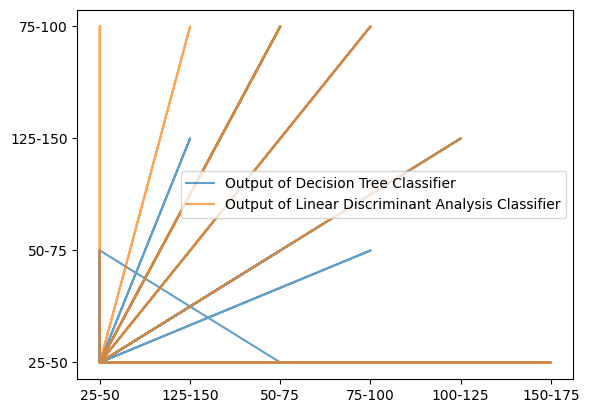

In [ ]:
plt.plot(y2_test,y2_pred,label="Output of Decision Tree Classifier",alpha=0.7)
plt.plot(y2_test,y22_pred,label="Output of Linear Discriminant Analysis Classifier",alpha=0.7)
plt.legend()
plt.show()

Here we can see that the models perform well in different areas. Overall, as the average of the stock price increases, the decision tree classifier performs better.